## Time Series Analysis on 'sales-of-shampoo.csv'

In [41]:
import pandas as pd
from pandas import datetime
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

## Data Load and Prepration

In [3]:
#load data and repalce column names
df = pd.read_csv('sales-of-shampoo.csv')
df.columns = ['Month', 'sales']
df.head()


,Month,sales
0,1-Jan,266.0
1,2-Jan,145.9
2,3-Jan,183.1
3,4-Jan,119.3
4,5-Jan,180.3


In [4]:
#month is not in suitable format, generating new same range for time
time = pd.date_range(start ='1901-1-1', periods = 36, freq ='m')
df['month']=time
df.head()

,Month,sales,month
0,1-Jan,266.0,1901-01-31
1,2-Jan,145.9,1901-02-28
2,3-Jan,183.1,1901-03-31
3,4-Jan,119.3,1901-04-30
4,5-Jan,180.3,1901-05-31


In [5]:
#drop original month
df.drop('Month', axis=1, inplace=True)

In [6]:
#set new month as index
df.set_index('month', drop=True, inplace=True)


In [7]:
#check data
df.head()

,sales
month,
1901-01-31,266.0
1901-02-28,145.9
1901-03-31,183.1
1901-04-30,119.3
1901-05-31,180.3


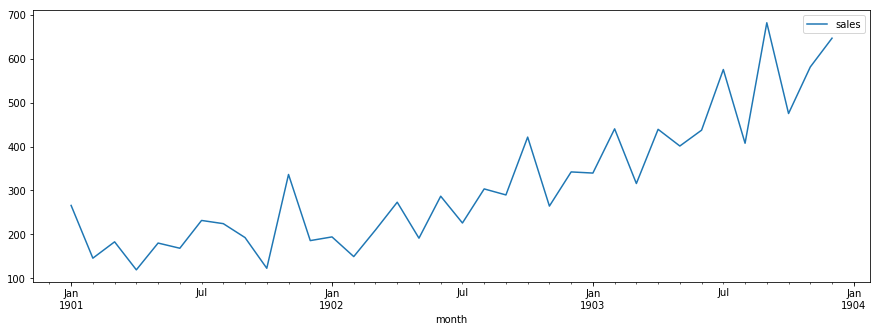

In [21]:
#plotting original series
df.plot(figsize=(15,5))
plt.show()

# EDA

In [9]:
#check for null
df.isnull().sum()

sales    0
dtype: int64

In [10]:
#explicit check for type
df.dtypes

sales    float64
dtype: object

In [11]:
#extracting months from the index
series = df.copy()
type(series.index.day)
print(series.index.month)

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,
             6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
            11, 12],
           dtype='int64', name='month')


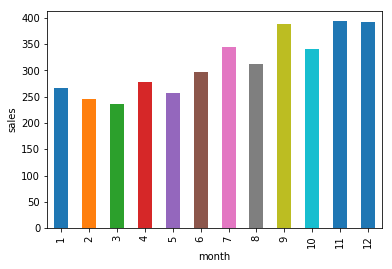

In [12]:
#Month wise data distribution
series.groupby(series.index.month)['sales'].mean().plot.bar()

plt.ylabel('sales')
plt.show()

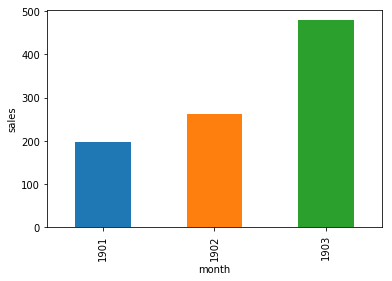

In [13]:
#Year wise data distribution
series.groupby(series.index.year)['sales'].mean().plot.bar()

plt.ylabel('sales')
plt.show()

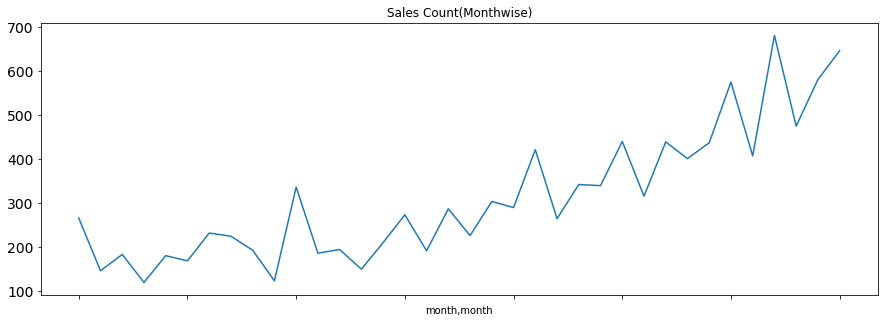

In [14]:
temp=series.groupby([series.index.year, series.index.month])['sales'].mean() 
temp.plot(figsize=(15,5), title= 'Sales Count(Monthwise)', fontsize=14)

### Train Test Split

In [23]:
train=series.loc['1901-01-31':'1903-06-30']
valid = series.loc['1903-07-31':] # taking last 6 month data for validation of model

In [66]:
train.head(),  valid.tail()

(            sales
 month            
 1901-01-31  266.0
 1901-02-28  145.9
 1901-03-31  183.1
 1901-04-30  119.3
 1901-05-31  180.3,             sales
 month            
 1903-08-31  407.6
 1903-09-30  682.0
 1903-10-31  475.3
 1903-11-30  581.3
 1903-12-31  646.9)

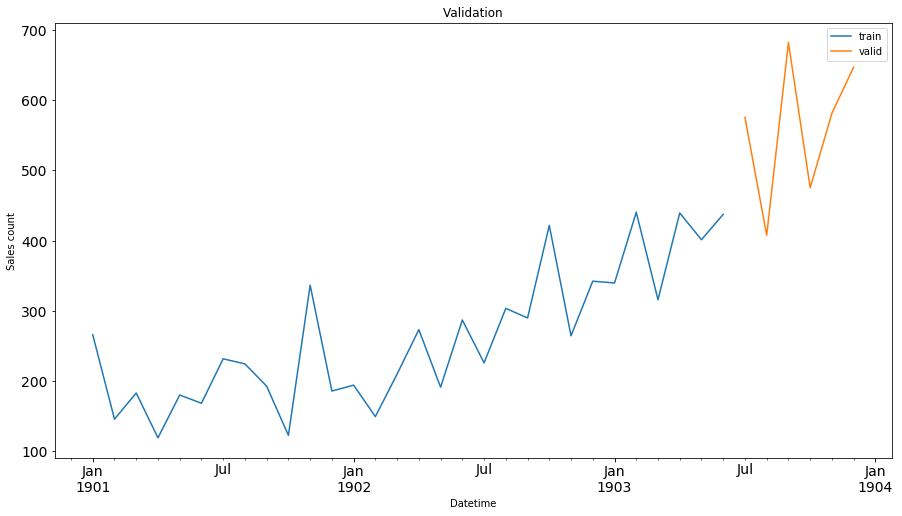

In [17]:
#plotting train and test in the same graph to observe the trend 
train.sales.plot(figsize=(15,8), title= 'Training set', fontsize=14, label='train') 
valid.sales.plot(figsize=(15,8), title= 'Validation', fontsize=14, label='valid') 
plt.xlabel("Datetime") 
plt.ylabel("Sales count")
plt.legend(loc='best')
plt.show()

# Check for sationarity


 Checking Stationarity

 Method 1. Plotting Rolling Stats


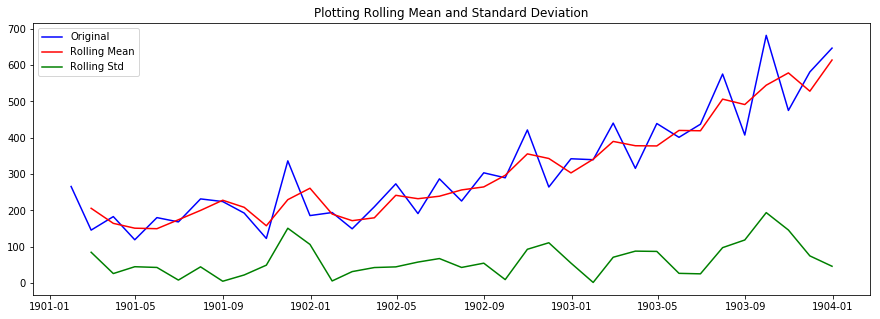


 Method 2. Dickey Fuller Test
Test Statistic               3.060142
p-value                      1.000000
#lag-used                   10.000000
No. of Observations Used    25.000000
Critical Value 1%           -3.723863
Critical Value 5%           -2.986489
Critical Value 10%          -2.632800
dtype: float64


In [24]:
from statsmodels.tsa.stattools import adfuller
print("\n Checking Stationarity")
#method 1: 
def plot_roll_stats(timeseries):
    print("="*100)
    print("\n Method 1. Plotting Rolling Stats")
    print("="*100)
    roll_mean = timeseries.rolling(window=2).mean()
    roll_std = timeseries.rolling(window=2).std()
    #print(f'{roll_mean},  {roll_std}')
    
    plt.figure(figsize=(15,5))
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(roll_mean, color='Red', label='Rolling Mean')
    plt.plot(roll_std, color='Green', label='Rolling Std')
    
    plt.title('Plotting Rolling Mean and Standard Deviation')
    plt.legend(loc='upper left')
    plt.show()
    
    
# method 2
def dickey_fuller_test(timeseries):
    plot_roll_stats(timeseries)     # call to first method
    print("="*100)
    print("\n Method 2. Dickey Fuller Test")
    print("="*100)
    
    #the test
    df_test= adfuller(timeseries)
    dfTestOut = pd.Series(df_test[0:4], index=['Test Statistic', 'p-value', '#lag-used', 'No. of Observations Used'])
    
    for key,value in df_test[4].items():
        dfTestOut[f'Critical Value {key}'] = value
    print(dfTestOut)
from matplotlib.pylab import rcParams 
rcParams['figure.figsize'] = 20,10

#call sationarity test function
dickey_fuller_test(df['sales'])


Test Statistic > Critical Value, so not stationary

## Removing Trend

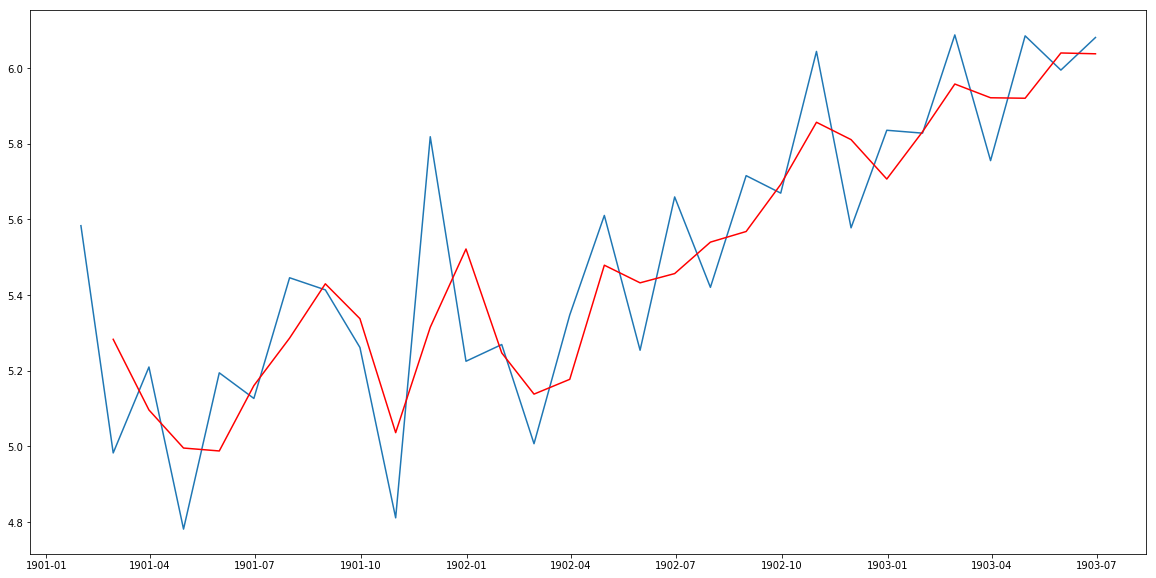

In [25]:
Train_log = np.log(train['sales']) 
valid_log = np.log(valid['sales'])
moving_avg = Train_log.rolling(2).mean()
plt.plot(Train_log) 
plt.plot(moving_avg, color = 'red') 
plt.show()

**we can observe an increasing trend. Now we will remove this increasing trend to make our time series stationary.**


 Method 1. Plotting Rolling Stats


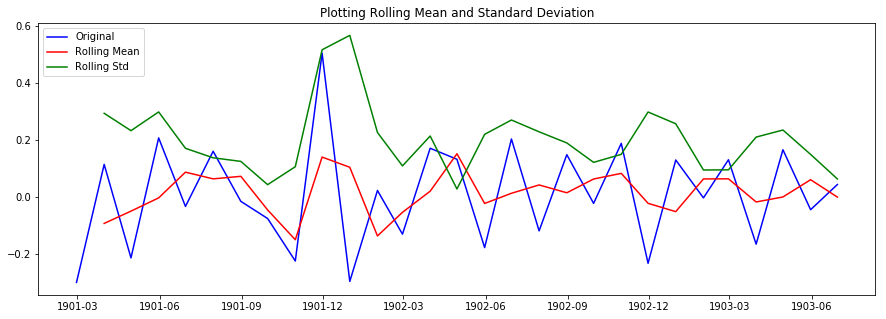


 Method 2. Dickey Fuller Test
Test Statistic              -3.024831
p-value                      0.032640
#lag-used                    9.000000
No. of Observations Used    19.000000
Critical Value 1%           -3.832603
Critical Value 5%           -3.031227
Critical Value 10%          -2.655520
dtype: float64


In [27]:
train_log_moving_avg_diff = Train_log - moving_avg
train_log_moving_avg_diff.dropna(inplace = True)

# check stationarity 
dickey_fuller_test(train_log_moving_avg_diff)


**Observation:** Now we can observe that **Test Statistic<Critical Value 10%**, hence series is stationary now

#### Differencing can help to make the series stable and eliminate the trend.


 Method 1. Plotting Rolling Stats


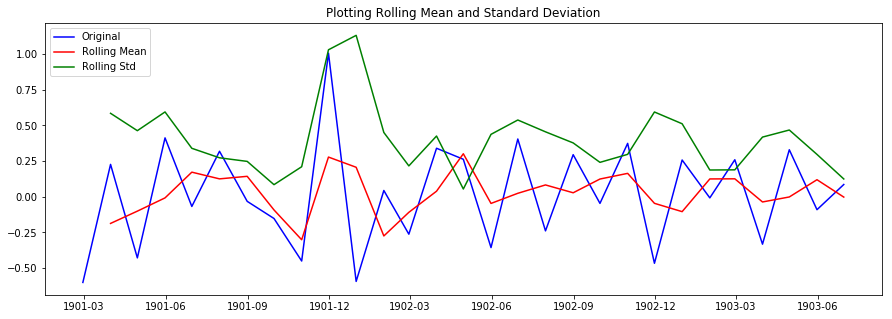


 Method 2. Dickey Fuller Test
Test Statistic              -3.024831
p-value                      0.032640
#lag-used                    9.000000
No. of Observations Used    19.000000
Critical Value 1%           -3.832603
Critical Value 5%           -3.031227
Critical Value 10%          -2.655520
dtype: float64


In [29]:
train_log_diff = Train_log - Train_log.shift(1) 
train_log_diff.dropna(inplace = True)



#test stationarity
dickey_fuller_test(train_log_diff)

# Removing Seasonality

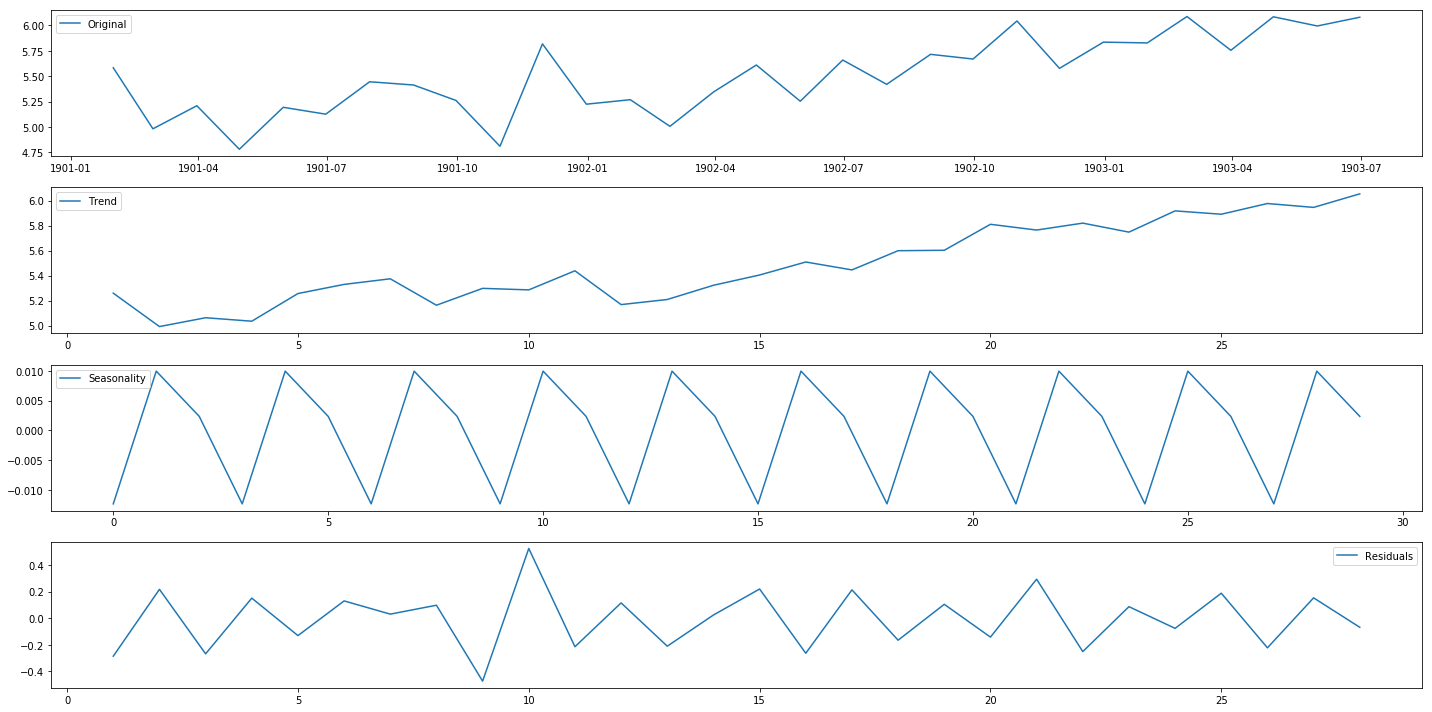

In [30]:
from statsmodels.tsa.seasonal import seasonal_decompose 
decomposition = seasonal_decompose(pd.DataFrame(Train_log).sales.values, freq = 3) 

trend = decomposition.trend 
seasonal = decomposition.seasonal 
residual = decomposition.resid

plt.subplot(411) 
plt.plot(Train_log, label='Original') 
plt.legend(loc='best') 
plt.subplot(412) 
plt.plot(trend, label='Trend') 
plt.legend(loc='best') 
plt.subplot(413) 
plt.plot(seasonal,label='Seasonality') 
plt.legend(loc='best') 
plt.subplot(414) 
plt.plot(residual, label='Residuals') 
plt.legend(loc='best') 
plt.tight_layout() 
plt.show()

#### Observation:

We can see the trend, residuals and the seasonality clearly in the above graph. Seasonality shows a constant trend in counter


 Method 1. Plotting Rolling Stats


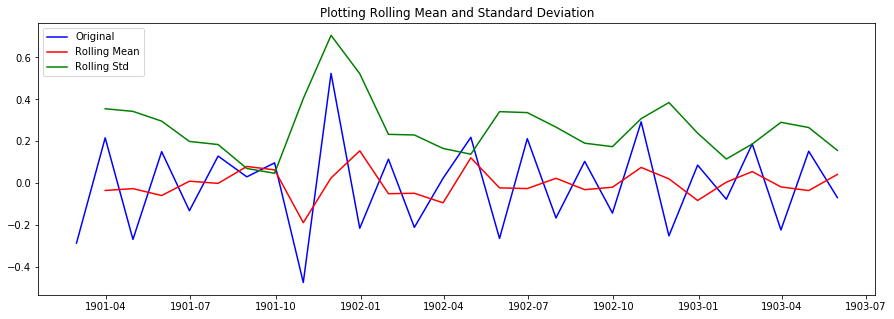


 Method 2. Dickey Fuller Test
Test Statistic              -2.773764
p-value                      0.062120
#lag-used                    9.000000
No. of Observations Used    18.000000
Critical Value 1%           -3.859073
Critical Value 5%           -3.042046
Critical Value 10%          -2.660906
dtype: float64


In [34]:
train_log_decompose = pd.DataFrame(residual) 
train_log_decompose['date'] = Train_log.index 
train_log_decompose.set_index('date', inplace = True)
train_log_decompose.dropna(inplace=True) 
#test stationarity
dickey_fuller_test(train_log_decompose[0])

**Observation:** We can observe that Test Statistic is very small now, and less then critical value 10%

### Forecasting the time series using ARIMA
First of all we will fit the ARIMA model on our time series for that we have to find the optimized values for the p,d,q parameters.

In [51]:
from statsmodels.tsa.stattools import acf, pacf 
lag_acf = acf(train_log_diff.dropna(), nlags=10) 
lag_pacf = pacf(train_log_diff.dropna(), nlags=10, method='ols')

In [52]:
lag_acf

array([ 1.        , -0.63755224,  0.35363965, -0.3711445 ,  0.33706228,
       -0.1961399 ,  0.10972155, -0.1119107 ,  0.1185759 , -0.14274525,
        0.09927254])

In [53]:
lag_pacf

array([ 1.        , -0.63797082, -0.13940436, -0.45323837, -0.2470853 ,
       -0.14891477, -0.07638961,  0.11608209,  0.22195646, -0.3791358 ,
       -0.39162693])

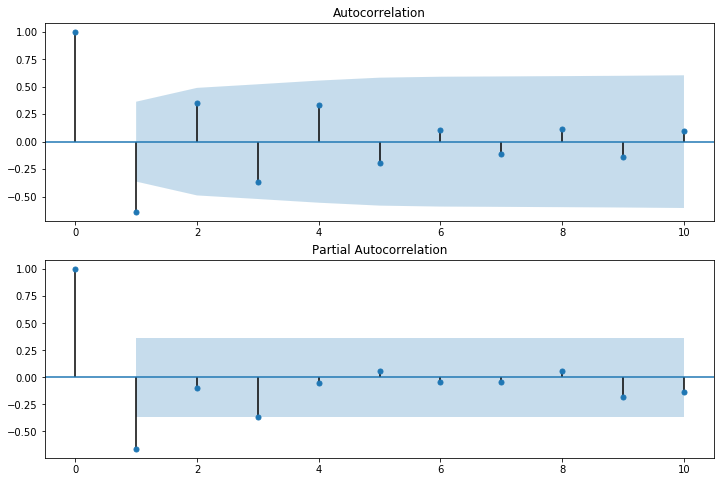

In [54]:
# Auto-correlation Function and Partial autocorrelation Function plot 
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train_log_diff.values.squeeze(), lags=10, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train_log_diff, lags=10, ax=ax2)

##### Plot Using 90% confidence interval

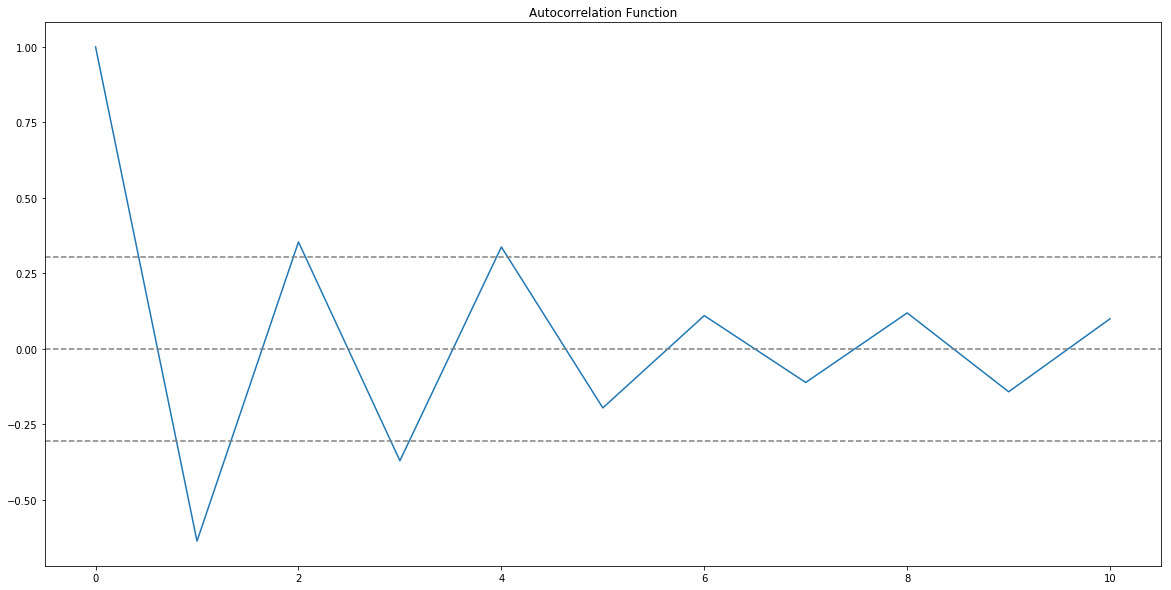

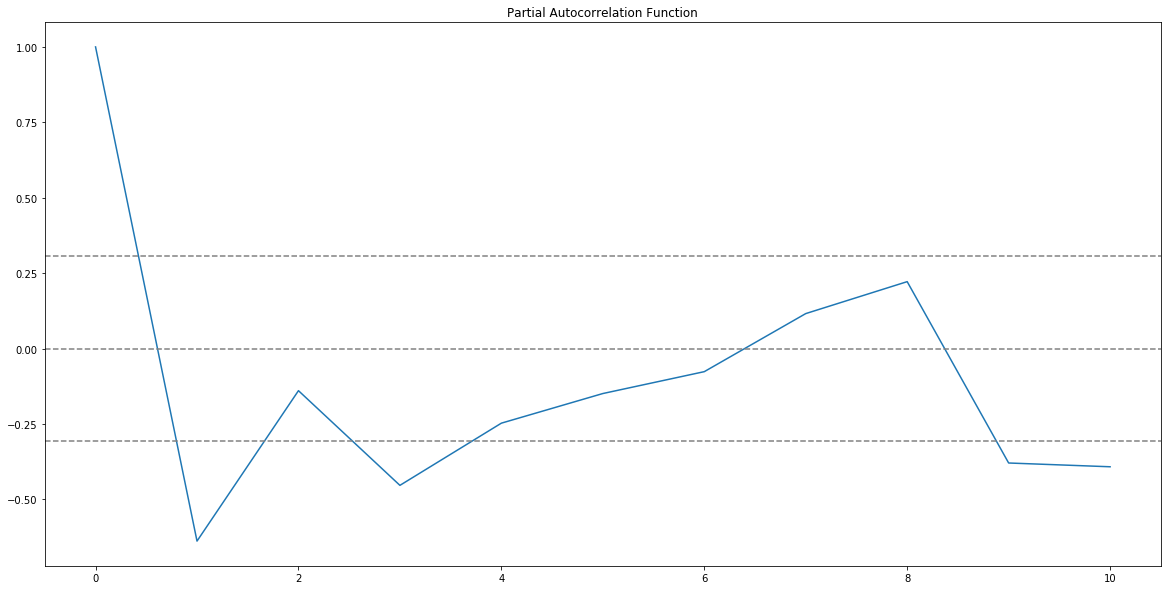

In [58]:
plt.plot(lag_acf) 
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.645/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray')
plt.axhline(y=1.645/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray')
plt.title('Autocorrelation Function') 
plt.show() 
plt.plot(lag_pacf) 
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.645/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray')
plt.axhline(y=1.645/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray') 
plt.title('Partial Autocorrelation Function') 
plt.show()

- p value is the lag value where the PACF chart crosses the upper confidence interval for the first time. It can be noticed that in this case p=1.
- q value is the lag value where the ACF chart crosses the upper confidence interval for the first time. It can be noticed that in this case q=1.

- Now we will make the ARIMA model as we have the p,q values. We will make the AR and MA model separately and then combine them together.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be

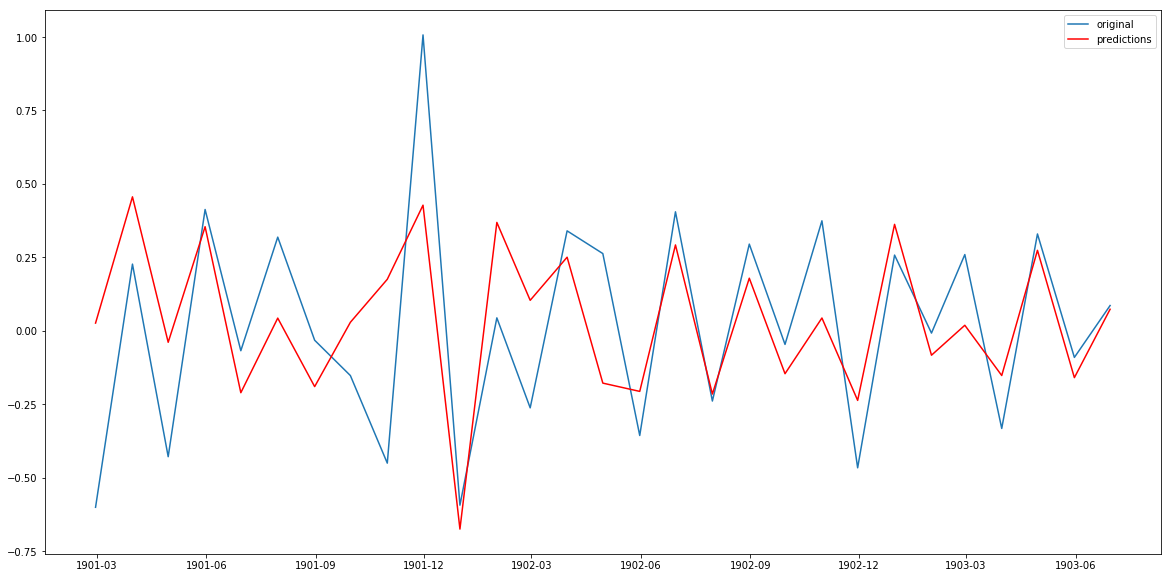

In [88]:
#AR model
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(Train_log, order=(2, 1, 0))  # here the q value is zero since it is just the AR model 
results_AR = model.fit(disp=-1)  
plt.plot(train_log_diff.dropna(), label='original') 
plt.plot(results_AR.fittedvalues, color='red', label='predictions') 
plt.legend(loc='best') 
plt.show()

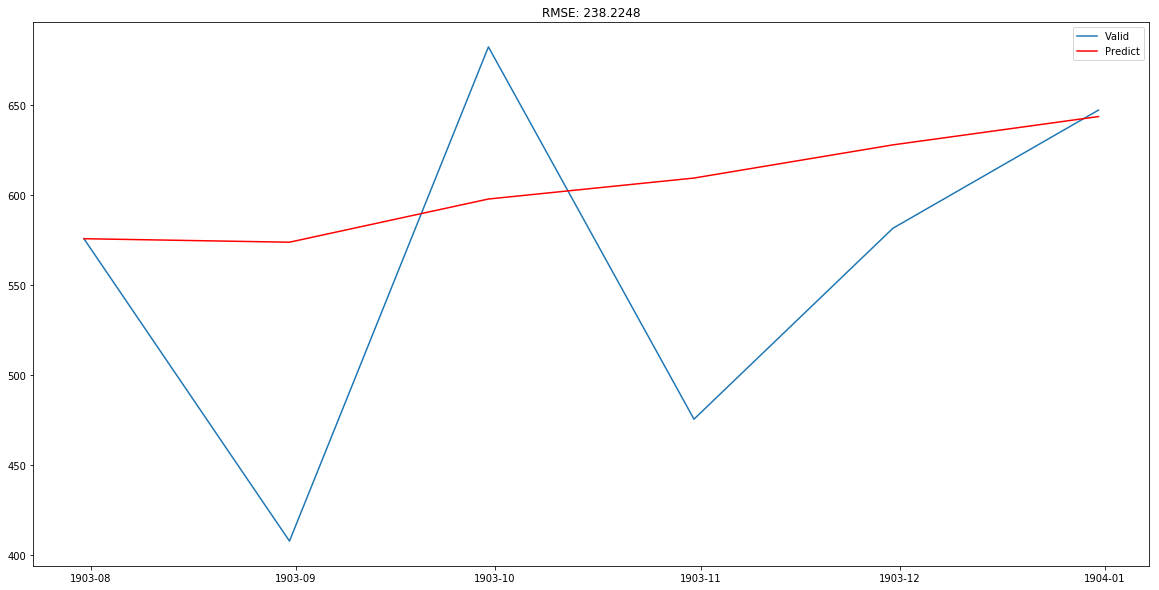

In [91]:
#model validation
AR_predict=results_AR.predict(start="'1903-07-31'", end="1903-12-31") 
AR_predict=AR_predict.cumsum().shift().fillna(0) 
AR_predict1=pd.Series(np.ones(valid.shape[0]) * np.log(valid['sales'])[0], index = valid.index) 
AR_predict1=AR_predict1.add(AR_predict,fill_value=0) 
AR_predict = np.exp(AR_predict1)
plt.plot(valid['sales'], label = "Valid") 
plt.plot(AR_predict, color = 'red', label = "Predict") 
plt.legend(loc= 'best') 
plt.title('RMSE: %.4f'% (np.sqrt(np.dot(AR_predict, valid['sales']))/valid.shape[0])) 
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


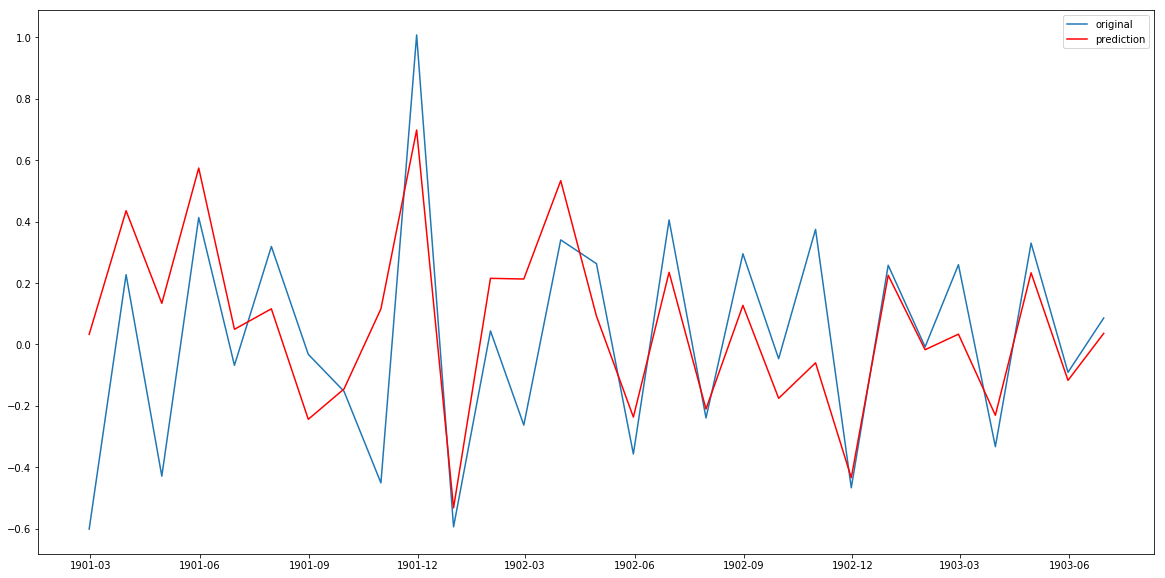

In [72]:
#MA model
model = ARIMA(Train_log, order=(0, 1, 2))  # here the p value is zero since it is just the MA model 
results_MA = model.fit(disp=-1)  
plt.plot(train_log_diff.dropna(), label='original') 
plt.plot(results_MA.fittedvalues, color='red', label='prediction') 
plt.legend(loc='best') 
plt.show()

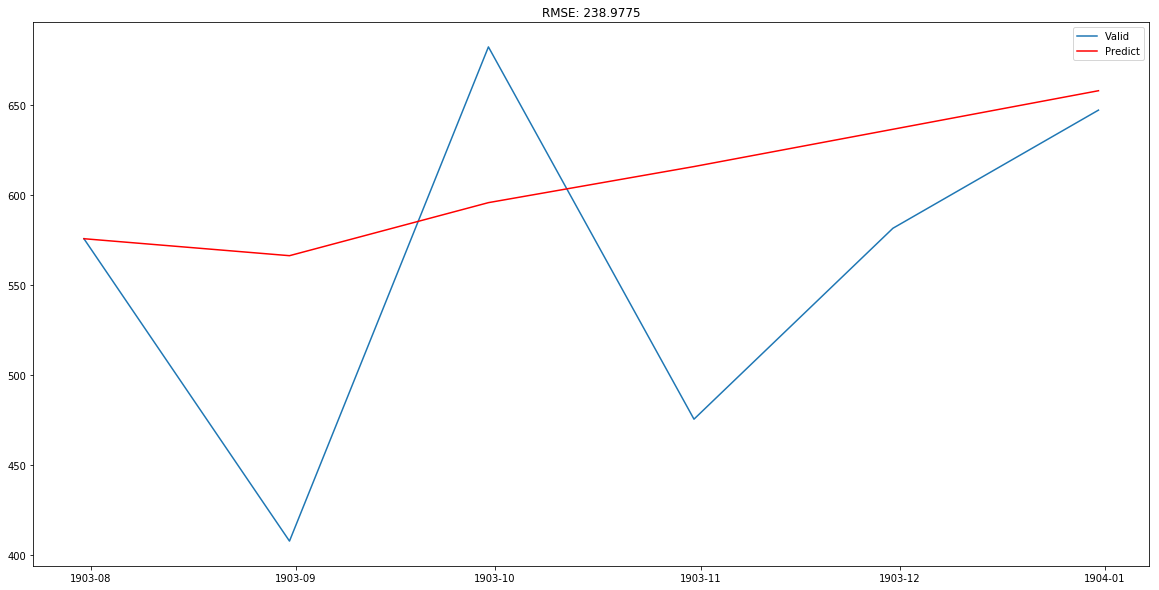

In [74]:
#model evaluation
MA_predict=results_MA.predict(start="'1903-07-31'", end="1903-12-31")
MA_predict=MA_predict.cumsum().shift().fillna(0) 
MA_predict1=pd.Series(np.ones(valid.shape[0]) * np.log(valid['sales'])[0], index = valid.index) 
MA_predict1=MA_predict1.add(MA_predict,fill_value=0) 
MA_predict = np.exp(MA_predict1)
plt.plot(valid['sales'], label = "Valid") 
plt.plot(MA_predict, color = 'red', label = "Predict") 
plt.legend(loc= 'best') 
plt.title('RMSE: %.4f'% (np.sqrt(np.dot(MA_predict, valid['sales']))/valid.shape[0])) 
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


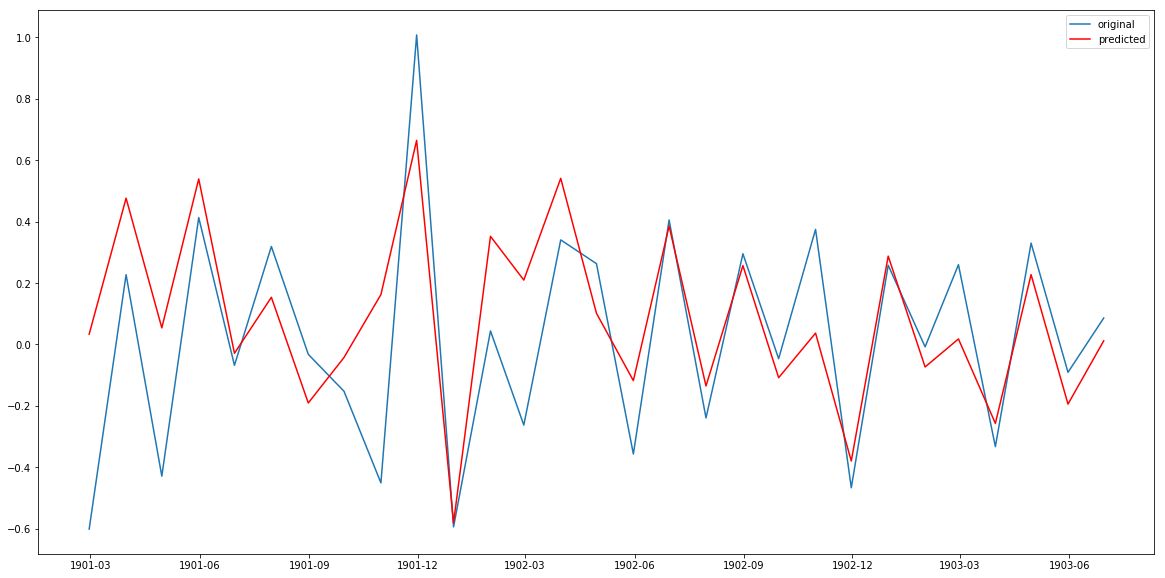

In [79]:
#Combined ARIMA model
model = ARIMA(Train_log, order=(2, 1, 1))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(train_log_diff.dropna(),  label='original') 
plt.plot(results_ARIMA.fittedvalues, color='red', label='predicted') 
plt.legend(loc='best') 
plt.show()

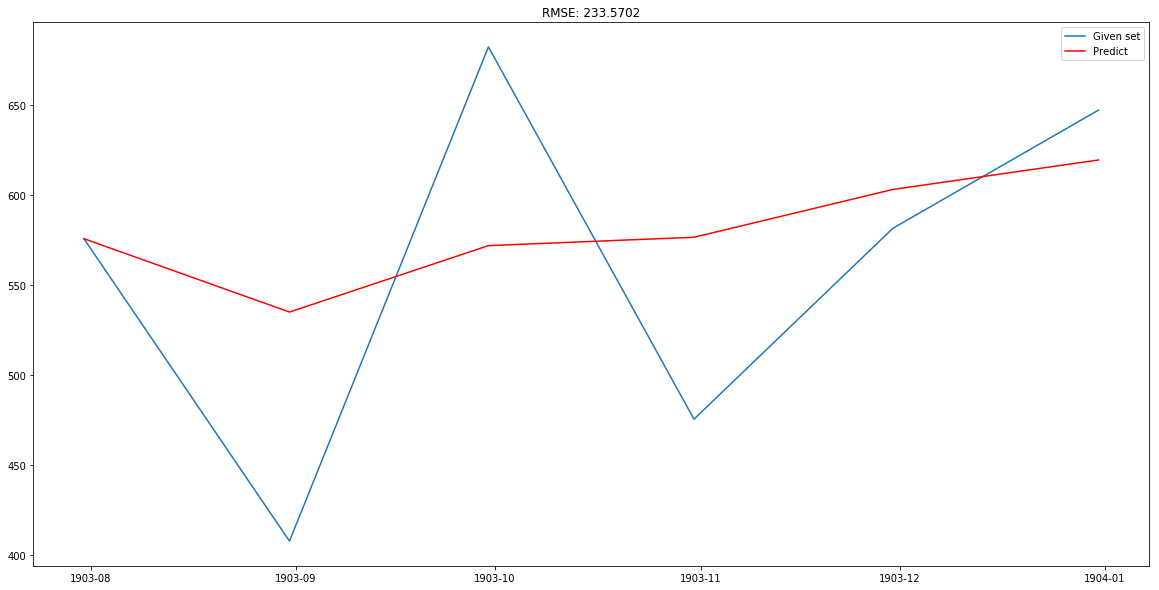

In [78]:
def check_prediction_diff(predict_diff, given_set):
    predict_diff= predict_diff.cumsum().shift().fillna(0)
    predict_base = pd.Series(np.ones(given_set.shape[0]) * np.log(given_set['sales'])[0], index = given_set.index)
    predict_log = predict_base.add(predict_diff,fill_value=0)
    predict = np.exp(predict_log)

    plt.plot(given_set['sales'], label = "Given set")
    plt.plot(predict, color = 'red', label = "Predict")
    plt.legend(loc= 'best')
    plt.title('RMSE: %.4f'% (np.sqrt(np.dot(predict, given_set['sales']))/given_set.shape[0]))
    plt.show()

def check_prediction_log(predict_log, given_set):
    predict = np.exp(predict_log)
 
    plt.plot(given_set['sales'], label = "Given set")
    plt.plot(predict, color = 'red', label = "Predict")
    plt.legend(loc= 'best')
    plt.title('RMSE: %.4f'% (np.sqrt(np.dot(predict, given_set['sales']))/given_set.shape[0]))
    plt.show()


ARIMA_predict_diff=results_ARIMA.predict(start="'1903-07-31'", end="1903-12-31")
check_prediction_diff(ARIMA_predict_diff, valid)